In [1]:
%matplotlib inline

In [2]:
import gym
import math
import random
from tqdm import tqdm_notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from collections import deque
from itertools import count
from copy import deepcopy
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical

# создаем энвайронмент с игрой
env = gym.make('Breakout-v0').unwrapped
# точное количество пропускаемых кадров
env.frameskip = 4

# настраиваем matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display    
print("Is python : {}".format(is_ipython))

# выбираем девайс для игры
DEVICE_ID = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(DEVICE_ID)
print("Device : {}".format(device))

# запоминаем, сколько действий в игре
ACTIONS_NUM = env.action_space.n
print("Number of actions : {}".format(ACTIONS_NUM))

Is python : True
Device : cuda
Number of actions : 4


In [3]:
STATE_SIZE = 4
STATE_W = 84
STATE_H = 84
MEMSIZE = 100000

# Класс для хранения состояния игры. 
# В качестве состояния используются состеканные 4 последовательных кадра игры.
class StateHolder:
    def __init__(self, new_screen):
        self.queue = deque(maxlen=STATE_SIZE)
        for _ in range(STATE_SIZE):
            self.queue.append(new_screen)
    
    def push(self,new_screen):
        self.queue.append(new_screen)
        
    def get(self):
        return torch.cat([screen for screen in self.queue]).unsqueeze(dim=0)
        
    def reset(self):
        self.queue.clear()
    
    
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:

    def __init__(self, capacity = MEMSIZE):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        #Положить переход в память
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        #Получить сэмпл из памяти
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
# Архитектуру сети (DQN)
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        nn.init.xavier_normal_(self.conv1.weight, gain=nn.init.calculate_gain('conv2d'))
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        nn.init.xavier_normal_(self.conv2.weight, gain=nn.init.calculate_gain('conv2d'))
        
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        nn.init.xavier_normal_(self.conv3.weight, gain=nn.init.calculate_gain('conv2d'))
        
        self.prehead = nn.Linear(7 * 7 * 64, 512)
        nn.init.xavier_normal_(self.prehead.weight, gain=nn.init.calculate_gain('relu')) 
        
        self.head = nn.Linear(512, 4)
        nn.init.xavier_normal_(self.head.weight, gain=nn.init.calculate_gain('linear'))        

        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.prehead(x.view(x.size(0), -1)))
        return self.head(x)

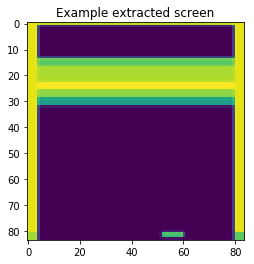

In [5]:
# Тут блок с кодом, генерирующим 1 кадр игры
resize = T.Compose([T.ToPILImage(),
                    T.Resize( (STATE_W, STATE_H), interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_screen():
    screen = env.render(mode='rgb_array')
    screen = np.dot(screen[...,:3], [0.299, 0.587, 0.114])
    screen = screen[30:195,:]
    screen = np.ascontiguousarray(screen, dtype=np.uint8).reshape(screen.shape[0],screen.shape[1],1)
    return resize(screen).mul(255).type(torch.ByteTensor).to(device).detach()

# преобразование байта во флоат
def byteToFloat(b):
    return b.type(torch.cuda.FloatTensor).to(device)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().reshape(-1,84).numpy(),interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [6]:
# Стандартный метод для выбора нового действия из лекции

policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-4, eps=0.001, alpha=0.95)
memory = ReplayMemory()

def select_action(state, eps_threshold):
    sample = random.random()
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(byteToFloat(state)).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(ACTIONS_NUM)]], device=device, dtype=torch.long)

train_rewards = []

mean_size = 100
mean_step = 1

def plot_rewards(rewards = train_rewards, name = "Train"):
    plt.figure(2)
    plt.clf()
    plt.title(name)
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(rewards)
    # Строим график среднего вознаграждения по 100 последним эпизодам
    if len(rewards) > mean_size:
        means = np.array([rewards[i:i+mean_size:] for i in range(0, len(rewards) - mean_size, mean_step)]).mean(1)
        means = np.concatenate((np.zeros(mean_size - 1), means))
        plt.plot(means)

In [7]:
# Еще немного методов из лекции

BATCH_SIZE = 32
GAMMA = 0.99

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    # выбираем новый батч
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Для всех состояний считаем маску не финальнсти и конкантенируем их
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Считаем Q(s_t, a) - модель дает Q(s_t), затем мы выбираем
    # колонки, которые соответствуют нашим действиям на щаге
    state_action_values = policy_net(byteToFloat(state_batch)).gather(1, action_batch)

    # Подсчитываем ценность состяония V(s_{t+1}) для всех последующмх состояний.
    next_state_values = torch.zeros(BATCH_SIZE, device=device).detach()
    next_state_values[non_final_mask] = target_net(byteToFloat(non_final_next_states)).max(1)[0].detach() # берем значение максимума
    
    # Считаем ожидаемое значение функции оценки ценности действия  Q-values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Считаем ошибку Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Оптимизация модели
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    del non_final_mask
    del non_final_next_states
    del state_batch
    del action_batch
    del reward_batch
    del state_action_values
    del next_state_values
    del expected_state_action_values
    del loss

Episode : 0 Steps done: 134 Episode score : 0.0 Mean score : 0.0
Episode : 1 Steps done: 386 Episode score : 3.0 Mean score : 1.5
Episode : 2 Steps done: 586 Episode score : 2.0 Mean score : 1.6666666666666667
Episode : 3 Steps done: 746 Episode score : 1.0 Mean score : 1.5
Episode : 4 Steps done: 915 Episode score : 1.0 Mean score : 1.4
Episode : 5 Steps done: 1131 Episode score : 2.0 Mean score : 1.5
Episode : 6 Steps done: 1364 Episode score : 2.0 Mean score : 1.5714285714285714
Episode : 7 Steps done: 1500 Episode score : 0.0 Mean score : 1.375
Episode : 8 Steps done: 1704 Episode score : 2.0 Mean score : 1.4444444444444444
Episode : 9 Steps done: 1836 Episode score : 0.0 Mean score : 1.3
Episode : 10 Steps done: 2087 Episode score : 3.0 Mean score : 1.4545454545454546
Episode : 11 Steps done: 2247 Episode score : 1.0 Mean score : 1.4166666666666667
Episode : 12 Steps done: 2476 Episode score : 2.0 Mean score : 1.4615384615384615
Episode : 13 Steps done: 2617 Episode score : 0.0 Me

Episode : 104 Steps done: 19267 Episode score : 0.0 Mean score : 1.23
Episode : 105 Steps done: 19511 Episode score : 3.0 Mean score : 1.24
Episode : 106 Steps done: 19636 Episode score : 0.0 Mean score : 1.22
Episode : 107 Steps done: 19767 Episode score : 0.0 Mean score : 1.22
Episode : 108 Steps done: 19974 Episode score : 2.0 Mean score : 1.22
Episode : 109 Steps done: 20271 Episode score : 4.0 Mean score : 1.26
Episode : 110 Steps done: 20411 Episode score : 0.0 Mean score : 1.23
Episode : 111 Steps done: 20538 Episode score : 0.0 Mean score : 1.22
Episode : 112 Steps done: 20667 Episode score : 0.0 Mean score : 1.2
Episode : 113 Steps done: 20852 Episode score : 1.0 Mean score : 1.21
Episode : 114 Steps done: 21024 Episode score : 1.0 Mean score : 1.2
Episode : 115 Steps done: 21199 Episode score : 1.0 Mean score : 1.2
Episode : 116 Steps done: 21565 Episode score : 6.0 Mean score : 1.19
Episode : 117 Steps done: 21701 Episode score : 0.0 Mean score : 1.17
Episode : 118 Steps don

Episode : 222 Steps done: 41414 Episode score : 1.0 Mean score : 1.4
Episode : 223 Steps done: 41665 Episode score : 3.0 Mean score : 1.41
Episode : 224 Steps done: 41877 Episode score : 2.0 Mean score : 1.43
Episode : 225 Steps done: 42046 Episode score : 1.0 Mean score : 1.44
Episode : 226 Steps done: 42182 Episode score : 0.0 Mean score : 1.44
Episode : 227 Steps done: 42382 Episode score : 2.0 Mean score : 1.46
Episode : 228 Steps done: 42514 Episode score : 0.0 Mean score : 1.42
Episode : 229 Steps done: 42653 Episode score : 0.0 Mean score : 1.42
Episode : 230 Steps done: 42837 Episode score : 1.0 Mean score : 1.42
Episode : 231 Steps done: 42964 Episode score : 0.0 Mean score : 1.38
Episode : 232 Steps done: 43125 Episode score : 0.0 Mean score : 1.36
Episode : 233 Steps done: 43357 Episode score : 2.0 Mean score : 1.38
Episode : 234 Steps done: 43606 Episode score : 3.0 Mean score : 1.39
Episode : 235 Steps done: 43763 Episode score : 1.0 Mean score : 1.38
Episode : 236 Steps d

Episode : 340 Steps done: 63132 Episode score : 3.0 Mean score : 1.38
Episode : 341 Steps done: 63269 Episode score : 0.0 Mean score : 1.38
Episode : 342 Steps done: 63403 Episode score : 0.0 Mean score : 1.37
Episode : 343 Steps done: 63616 Episode score : 2.0 Mean score : 1.37
Episode : 344 Steps done: 63773 Episode score : 1.0 Mean score : 1.36
Episode : 345 Steps done: 63984 Episode score : 2.0 Mean score : 1.38
Episode : 346 Steps done: 64241 Episode score : 3.0 Mean score : 1.39
Episode : 347 Steps done: 64386 Episode score : 0.0 Mean score : 1.34
Episode : 348 Steps done: 64593 Episode score : 2.0 Mean score : 1.35
Episode : 349 Steps done: 64717 Episode score : 0.0 Mean score : 1.3
Episode : 350 Steps done: 64848 Episode score : 0.0 Mean score : 1.29
Episode : 351 Steps done: 64987 Episode score : 0.0 Mean score : 1.28
Episode : 352 Steps done: 65301 Episode score : 4.0 Mean score : 1.3
Episode : 353 Steps done: 65433 Episode score : 0.0 Mean score : 1.29
Episode : 354 Steps do

Episode : 458 Steps done: 85397 Episode score : 3.0 Mean score : 1.39
Episode : 459 Steps done: 85576 Episode score : 1.0 Mean score : 1.38
Episode : 460 Steps done: 85712 Episode score : 0.0 Mean score : 1.38
Episode : 461 Steps done: 85843 Episode score : 0.0 Mean score : 1.38
Episode : 462 Steps done: 85987 Episode score : 0.0 Mean score : 1.35
Episode : 463 Steps done: 86118 Episode score : 0.0 Mean score : 1.35
Episode : 464 Steps done: 86294 Episode score : 1.0 Mean score : 1.36
Episode : 465 Steps done: 86426 Episode score : 0.0 Mean score : 1.35
Episode : 466 Steps done: 86608 Episode score : 2.0 Mean score : 1.36
Episode : 467 Steps done: 86739 Episode score : 0.0 Mean score : 1.35
Episode : 468 Steps done: 86895 Episode score : 1.0 Mean score : 1.35
Episode : 469 Steps done: 87022 Episode score : 0.0 Mean score : 1.34
Episode : 470 Steps done: 87164 Episode score : 0.0 Mean score : 1.34
Episode : 471 Steps done: 87352 Episode score : 1.0 Mean score : 1.35
Episode : 472 Steps 

Episode : 575 Steps done: 105581 Episode score : 0.0 Mean score : 1.11
Episode : 576 Steps done: 105712 Episode score : 0.0 Mean score : 1.08
Episode : 577 Steps done: 105843 Episode score : 0.0 Mean score : 1.05
Episode : 578 Steps done: 106016 Episode score : 1.0 Mean score : 1.04
Episode : 579 Steps done: 106156 Episode score : 0.0 Mean score : 1.03
Episode : 580 Steps done: 106287 Episode score : 0.0 Mean score : 1.02
Episode : 581 Steps done: 106494 Episode score : 2.0 Mean score : 1.01
Episode : 582 Steps done: 106631 Episode score : 0.0 Mean score : 1.0
Episode : 583 Steps done: 106767 Episode score : 0.0 Mean score : 0.98
Episode : 584 Steps done: 106989 Episode score : 2.0 Mean score : 0.99
Episode : 585 Steps done: 107244 Episode score : 3.0 Mean score : 1.0
Episode : 586 Steps done: 107369 Episode score : 0.0 Mean score : 0.99
Episode : 587 Steps done: 107546 Episode score : 1.0 Mean score : 1.0
Episode : 588 Steps done: 107850 Episode score : 4.0 Mean score : 1.04
Episode :

Episode : 691 Steps done: 126217 Episode score : 0.0 Mean score : 1.19
Episode : 692 Steps done: 126402 Episode score : 2.0 Mean score : 1.2
Episode : 693 Steps done: 126529 Episode score : 0.0 Mean score : 1.2
Episode : 694 Steps done: 126733 Episode score : 2.0 Mean score : 1.2
Episode : 695 Steps done: 126954 Episode score : 2.0 Mean score : 1.21
Episode : 696 Steps done: 127225 Episode score : 4.0 Mean score : 1.25
Episode : 697 Steps done: 127363 Episode score : 0.0 Mean score : 1.24
Episode : 698 Steps done: 127585 Episode score : 2.0 Mean score : 1.24
Episode : 699 Steps done: 127860 Episode score : 3.0 Mean score : 1.24
Episode : 700 Steps done: 127988 Episode score : 0.0 Mean score : 1.24
Episode : 701 Steps done: 128167 Episode score : 1.0 Mean score : 1.22
Episode : 702 Steps done: 128365 Episode score : 1.0 Mean score : 1.22
Episode : 703 Steps done: 128519 Episode score : 1.0 Mean score : 1.23
Episode : 704 Steps done: 128681 Episode score : 1.0 Mean score : 1.23
Episode :

Episode : 807 Steps done: 147520 Episode score : 0.0 Mean score : 1.3
Episode : 808 Steps done: 147663 Episode score : 0.0 Mean score : 1.3
Episode : 809 Steps done: 147792 Episode score : 0.0 Mean score : 1.29
Episode : 810 Steps done: 147968 Episode score : 1.0 Mean score : 1.27
Episode : 811 Steps done: 148215 Episode score : 3.0 Mean score : 1.29
Episode : 812 Steps done: 148355 Episode score : 0.0 Mean score : 1.29
Episode : 813 Steps done: 148509 Episode score : 1.0 Mean score : 1.29
Episode : 814 Steps done: 148712 Episode score : 2.0 Mean score : 1.3
Episode : 815 Steps done: 148940 Episode score : 3.0 Mean score : 1.3
Episode : 816 Steps done: 149188 Episode score : 3.0 Mean score : 1.29
Episode : 817 Steps done: 149397 Episode score : 2.0 Mean score : 1.3
Episode : 818 Steps done: 149527 Episode score : 0.0 Mean score : 1.28
Episode : 819 Steps done: 149706 Episode score : 1.0 Mean score : 1.29
Episode : 820 Steps done: 149869 Episode score : 1.0 Mean score : 1.29
Episode : 8

Episode : 923 Steps done: 168830 Episode score : 2.0 Mean score : 1.39
Episode : 924 Steps done: 169080 Episode score : 3.0 Mean score : 1.4
Episode : 925 Steps done: 169212 Episode score : 0.0 Mean score : 1.39
Episode : 926 Steps done: 169373 Episode score : 1.0 Mean score : 1.4
Episode : 927 Steps done: 169501 Episode score : 0.0 Mean score : 1.4
Episode : 928 Steps done: 169632 Episode score : 0.0 Mean score : 1.39
Episode : 929 Steps done: 169764 Episode score : 0.0 Mean score : 1.36
Episode : 930 Steps done: 169892 Episode score : 0.0 Mean score : 1.35
Episode : 931 Steps done: 170094 Episode score : 2.0 Mean score : 1.37
Episode : 932 Steps done: 170292 Episode score : 2.0 Mean score : 1.39
Episode : 933 Steps done: 170420 Episode score : 0.0 Mean score : 1.39
Episode : 934 Steps done: 170622 Episode score : 2.0 Mean score : 1.41
Episode : 935 Steps done: 170922 Episode score : 4.0 Mean score : 1.43
Episode : 936 Steps done: 171130 Episode score : 2.0 Mean score : 1.45
Episode :

Episode : 1039 Steps done: 190349 Episode score : 1.0 Mean score : 1.45
Episode : 1040 Steps done: 190568 Episode score : 2.0 Mean score : 1.45
Episode : 1041 Steps done: 190698 Episode score : 0.0 Mean score : 1.44
Episode : 1042 Steps done: 190910 Episode score : 2.0 Mean score : 1.44
Episode : 1043 Steps done: 191061 Episode score : 1.0 Mean score : 1.45
Episode : 1044 Steps done: 191233 Episode score : 1.0 Mean score : 1.45
Episode : 1045 Steps done: 191411 Episode score : 1.0 Mean score : 1.44
Episode : 1046 Steps done: 191603 Episode score : 2.0 Mean score : 1.44
Episode : 1047 Steps done: 191733 Episode score : 0.0 Mean score : 1.43
Episode : 1048 Steps done: 192023 Episode score : 5.0 Mean score : 1.48
Episode : 1049 Steps done: 192158 Episode score : 0.0 Mean score : 1.46
Episode : 1050 Steps done: 192287 Episode score : 0.0 Mean score : 1.45
Episode : 1051 Steps done: 192493 Episode score : 2.0 Mean score : 1.47
Episode : 1052 Steps done: 192763 Episode score : 3.0 Mean score

Episode : 1153 Steps done: 211095 Episode score : 1.0 Mean score : 1.34
Episode : 1154 Steps done: 211360 Episode score : 4.0 Mean score : 1.37
Episode : 1155 Steps done: 211487 Episode score : 0.0 Mean score : 1.37
Episode : 1156 Steps done: 211661 Episode score : 1.0 Mean score : 1.37
Episode : 1157 Steps done: 211944 Episode score : 3.0 Mean score : 1.4
Episode : 1158 Steps done: 212103 Episode score : 1.0 Mean score : 1.37
Episode : 1159 Steps done: 212400 Episode score : 4.0 Mean score : 1.39
Episode : 1160 Steps done: 212582 Episode score : 1.0 Mean score : 1.39
Episode : 1161 Steps done: 212758 Episode score : 1.0 Mean score : 1.38
Episode : 1162 Steps done: 212886 Episode score : 0.0 Mean score : 1.35
Episode : 1163 Steps done: 213084 Episode score : 2.0 Mean score : 1.37
Episode : 1164 Steps done: 213206 Episode score : 0.0 Mean score : 1.37
Episode : 1165 Steps done: 213433 Episode score : 3.0 Mean score : 1.38
Episode : 1166 Steps done: 213639 Episode score : 2.0 Mean score 

Episode : 1267 Steps done: 231984 Episode score : 1.0 Mean score : 1.31
Episode : 1268 Steps done: 232192 Episode score : 2.0 Mean score : 1.31
Episode : 1269 Steps done: 232496 Episode score : 4.0 Mean score : 1.34
Episode : 1270 Steps done: 232721 Episode score : 3.0 Mean score : 1.34
Episode : 1271 Steps done: 232892 Episode score : 1.0 Mean score : 1.33
Episode : 1272 Steps done: 233049 Episode score : 1.0 Mean score : 1.33
Episode : 1273 Steps done: 233180 Episode score : 0.0 Mean score : 1.3
Episode : 1274 Steps done: 233482 Episode score : 4.0 Mean score : 1.3
Episode : 1275 Steps done: 233620 Episode score : 0.0 Mean score : 1.3
Episode : 1276 Steps done: 233744 Episode score : 0.0 Mean score : 1.3
Episode : 1277 Steps done: 233950 Episode score : 2.0 Mean score : 1.3
Episode : 1278 Steps done: 234173 Episode score : 2.0 Mean score : 1.27
Episode : 1279 Steps done: 234343 Episode score : 1.0 Mean score : 1.26
Episode : 1280 Steps done: 234546 Episode score : 2.0 Mean score : 1.

Episode : 1382 Steps done: 253734 Episode score : 1.0 Mean score : 1.51
Episode : 1383 Steps done: 253906 Episode score : 1.0 Mean score : 1.52
Episode : 1384 Steps done: 254131 Episode score : 2.0 Mean score : 1.52
Episode : 1385 Steps done: 254257 Episode score : 0.0 Mean score : 1.48
Episode : 1386 Steps done: 254559 Episode score : 4.0 Mean score : 1.51
Episode : 1387 Steps done: 254685 Episode score : 0.0 Mean score : 1.5
Episode : 1388 Steps done: 254843 Episode score : 1.0 Mean score : 1.5
Episode : 1389 Steps done: 254996 Episode score : 1.0 Mean score : 1.48
Episode : 1390 Steps done: 255127 Episode score : 0.0 Mean score : 1.48
Episode : 1391 Steps done: 255252 Episode score : 0.0 Mean score : 1.47
Episode : 1392 Steps done: 255377 Episode score : 0.0 Mean score : 1.47
Episode : 1393 Steps done: 255617 Episode score : 2.0 Mean score : 1.49
Episode : 1394 Steps done: 255787 Episode score : 1.0 Mean score : 1.5
Episode : 1395 Steps done: 255971 Episode score : 2.0 Mean score : 

Episode : 1497 Steps done: 274652 Episode score : 4.0 Mean score : 1.35
Episode : 1498 Steps done: 274778 Episode score : 0.0 Mean score : 1.35
Episode : 1499 Steps done: 274982 Episode score : 2.0 Mean score : 1.35
Episode : 1500 Steps done: 275218 Episode score : 2.0 Mean score : 1.36
Episode : 1501 Steps done: 275452 Episode score : 3.0 Mean score : 1.38
Episode : 1502 Steps done: 275685 Episode score : 3.0 Mean score : 1.41
Episode : 1503 Steps done: 275913 Episode score : 2.0 Mean score : 1.43
Episode : 1504 Steps done: 276114 Episode score : 2.0 Mean score : 1.43
Episode : 1505 Steps done: 276343 Episode score : 2.0 Mean score : 1.45
Episode : 1506 Steps done: 276599 Episode score : 3.0 Mean score : 1.48
Episode : 1507 Steps done: 276804 Episode score : 2.0 Mean score : 1.5
Episode : 1508 Steps done: 276974 Episode score : 1.0 Mean score : 1.49
Episode : 1509 Steps done: 277125 Episode score : 1.0 Mean score : 1.5
Episode : 1510 Steps done: 277299 Episode score : 1.0 Mean score :

Episode : 1611 Steps done: 296343 Episode score : 1.0 Mean score : 1.56
Episode : 1612 Steps done: 296619 Episode score : 3.0 Mean score : 1.56
Episode : 1613 Steps done: 296775 Episode score : 1.0 Mean score : 1.57
Episode : 1614 Steps done: 296984 Episode score : 2.0 Mean score : 1.57
Episode : 1615 Steps done: 297146 Episode score : 1.0 Mean score : 1.56
Episode : 1616 Steps done: 297277 Episode score : 0.0 Mean score : 1.56
Episode : 1617 Steps done: 297650 Episode score : 6.0 Mean score : 1.59
Episode : 1618 Steps done: 297854 Episode score : 2.0 Mean score : 1.6
Episode : 1619 Steps done: 298039 Episode score : 2.0 Mean score : 1.62
Episode : 1620 Steps done: 298277 Episode score : 3.0 Mean score : 1.64
Episode : 1621 Steps done: 298478 Episode score : 2.0 Mean score : 1.63
Episode : 1622 Steps done: 298756 Episode score : 4.0 Mean score : 1.64
Episode : 1623 Steps done: 298961 Episode score : 2.0 Mean score : 1.65
Episode : 1624 Steps done: 299162 Episode score : 2.0 Mean score 

Episode : 1725 Steps done: 319959 Episode score : 0.0 Mean score : 1.99
Episode : 1726 Steps done: 320258 Episode score : 4.0 Mean score : 2.02
Episode : 1727 Steps done: 320455 Episode score : 2.0 Mean score : 2.02
Episode : 1728 Steps done: 320702 Episode score : 3.0 Mean score : 2.02
Episode : 1729 Steps done: 320909 Episode score : 2.0 Mean score : 2.04
Episode : 1730 Steps done: 321061 Episode score : 1.0 Mean score : 2.03
Episode : 1731 Steps done: 321374 Episode score : 5.0 Mean score : 2.07
Episode : 1732 Steps done: 321573 Episode score : 2.0 Mean score : 2.08
Episode : 1733 Steps done: 321697 Episode score : 0.0 Mean score : 2.06
Episode : 1734 Steps done: 321964 Episode score : 3.0 Mean score : 2.08
Episode : 1735 Steps done: 322208 Episode score : 3.0 Mean score : 2.11
Episode : 1736 Steps done: 322406 Episode score : 2.0 Mean score : 2.12
Episode : 1737 Steps done: 322608 Episode score : 2.0 Mean score : 2.13
Episode : 1738 Steps done: 322861 Episode score : 3.0 Mean score

Episode : 1839 Steps done: 344868 Episode score : 3.0 Mean score : 2.33
Episode : 1840 Steps done: 345067 Episode score : 2.0 Mean score : 2.32
Episode : 1841 Steps done: 345285 Episode score : 2.0 Mean score : 2.32
Episode : 1842 Steps done: 345455 Episode score : 1.0 Mean score : 2.31
Episode : 1843 Steps done: 345660 Episode score : 2.0 Mean score : 2.33
Episode : 1844 Steps done: 345867 Episode score : 2.0 Mean score : 2.34
Episode : 1845 Steps done: 346081 Episode score : 2.0 Mean score : 2.32
Episode : 1846 Steps done: 346316 Episode score : 2.0 Mean score : 2.31
Episode : 1847 Steps done: 346447 Episode score : 0.0 Mean score : 2.31
Episode : 1848 Steps done: 346647 Episode score : 2.0 Mean score : 2.31
Episode : 1849 Steps done: 347057 Episode score : 6.0 Mean score : 2.35
Episode : 1850 Steps done: 347302 Episode score : 3.0 Mean score : 2.35
Episode : 1851 Steps done: 347500 Episode score : 2.0 Mean score : 2.35
Episode : 1852 Steps done: 347655 Episode score : 1.0 Mean score

Episode : 1953 Steps done: 371275 Episode score : 1.0 Mean score : 2.68
Episode : 1954 Steps done: 371449 Episode score : 1.0 Mean score : 2.68
Episode : 1955 Steps done: 371694 Episode score : 3.0 Mean score : 2.68
Episode : 1956 Steps done: 371915 Episode score : 2.0 Mean score : 2.69
Episode : 1957 Steps done: 372151 Episode score : 3.0 Mean score : 2.66
Episode : 1958 Steps done: 372282 Episode score : 0.0 Mean score : 2.62
Episode : 1959 Steps done: 372411 Episode score : 0.0 Mean score : 2.61
Episode : 1960 Steps done: 372564 Episode score : 1.0 Mean score : 2.57
Episode : 1961 Steps done: 372964 Episode score : 9.0 Mean score : 2.65
Episode : 1962 Steps done: 373210 Episode score : 3.0 Mean score : 2.67
Episode : 1963 Steps done: 373436 Episode score : 3.0 Mean score : 2.66
Episode : 1964 Steps done: 373824 Episode score : 6.0 Mean score : 2.71
Episode : 1965 Steps done: 374056 Episode score : 3.0 Mean score : 2.72
Episode : 1966 Steps done: 374305 Episode score : 3.0 Mean score

Episode : 2067 Steps done: 398524 Episode score : 2.0 Mean score : 2.87
Episode : 2068 Steps done: 398706 Episode score : 2.0 Mean score : 2.88
Episode : 2069 Steps done: 398957 Episode score : 3.0 Mean score : 2.89
Episode : 2070 Steps done: 399159 Episode score : 2.0 Mean score : 2.89
Episode : 2071 Steps done: 399418 Episode score : 4.0 Mean score : 2.89
Episode : 2072 Steps done: 399827 Episode score : 7.0 Mean score : 2.94
Episode : 2073 Steps done: 400104 Episode score : 4.0 Mean score : 2.97
Episode : 2074 Steps done: 400463 Episode score : 6.0 Mean score : 3.0
Episode : 2075 Steps done: 400694 Episode score : 3.0 Mean score : 3.0
Episode : 2076 Steps done: 400992 Episode score : 4.0 Mean score : 3.01
Episode : 2077 Steps done: 401129 Episode score : 0.0 Mean score : 2.99
Episode : 2078 Steps done: 401532 Episode score : 7.0 Mean score : 3.03
Episode : 2079 Steps done: 401842 Episode score : 5.0 Mean score : 3.06
Episode : 2080 Steps done: 401970 Episode score : 0.0 Mean score :

Episode : 2181 Steps done: 427259 Episode score : 1.0 Mean score : 3.24
Episode : 2182 Steps done: 427484 Episode score : 2.0 Mean score : 3.25
Episode : 2183 Steps done: 427711 Episode score : 3.0 Mean score : 3.26
Episode : 2184 Steps done: 427838 Episode score : 0.0 Mean score : 3.21
Episode : 2185 Steps done: 428120 Episode score : 4.0 Mean score : 3.21
Episode : 2186 Steps done: 428341 Episode score : 2.0 Mean score : 3.21
Episode : 2187 Steps done: 428671 Episode score : 5.0 Mean score : 3.22
Episode : 2188 Steps done: 428993 Episode score : 6.0 Mean score : 3.28
Episode : 2189 Steps done: 429192 Episode score : 2.0 Mean score : 3.24
Episode : 2190 Steps done: 429383 Episode score : 2.0 Mean score : 3.24
Episode : 2191 Steps done: 429582 Episode score : 2.0 Mean score : 3.22
Episode : 2192 Steps done: 429857 Episode score : 4.0 Mean score : 3.23
Episode : 2193 Steps done: 430103 Episode score : 4.0 Mean score : 3.23
Episode : 2194 Steps done: 430286 Episode score : 2.0 Mean score

Episode : 2295 Steps done: 456867 Episode score : 4.0 Mean score : 3.56
Episode : 2296 Steps done: 457104 Episode score : 3.0 Mean score : 3.56
Episode : 2297 Steps done: 457384 Episode score : 4.0 Mean score : 3.55
Episode : 2298 Steps done: 457683 Episode score : 5.0 Mean score : 3.54
Episode : 2299 Steps done: 458008 Episode score : 5.0 Mean score : 3.57
Episode : 2300 Steps done: 458241 Episode score : 3.0 Mean score : 3.57
Episode : 2301 Steps done: 458392 Episode score : 1.0 Mean score : 3.55
Episode : 2302 Steps done: 458718 Episode score : 5.0 Mean score : 3.5
Episode : 2303 Steps done: 458997 Episode score : 4.0 Mean score : 3.51
Episode : 2304 Steps done: 459314 Episode score : 5.0 Mean score : 3.53
Episode : 2305 Steps done: 459649 Episode score : 6.0 Mean score : 3.55
Episode : 2306 Steps done: 459807 Episode score : 1.0 Mean score : 3.52
Episode : 2307 Steps done: 460264 Episode score : 11.0 Mean score : 3.54
Episode : 2308 Steps done: 460543 Episode score : 4.0 Mean score

Episode : 2409 Steps done: 490824 Episode score : 5.0 Mean score : 4.6
Episode : 2410 Steps done: 491189 Episode score : 6.0 Mean score : 4.66
Episode : 2411 Steps done: 491490 Episode score : 4.0 Mean score : 4.66
Episode : 2412 Steps done: 491930 Episode score : 8.0 Mean score : 4.71
Episode : 2413 Steps done: 492314 Episode score : 9.0 Mean score : 4.73
Episode : 2414 Steps done: 492671 Episode score : 6.0 Mean score : 4.75
Episode : 2415 Steps done: 493048 Episode score : 7.0 Mean score : 4.78
Episode : 2416 Steps done: 493297 Episode score : 3.0 Mean score : 4.76
Episode : 2417 Steps done: 493575 Episode score : 4.0 Mean score : 4.79
Episode : 2418 Steps done: 493756 Episode score : 2.0 Mean score : 4.79
Episode : 2419 Steps done: 494036 Episode score : 3.0 Mean score : 4.78
Episode : 2420 Steps done: 494378 Episode score : 6.0 Mean score : 4.79
Episode : 2421 Steps done: 494576 Episode score : 2.0 Mean score : 4.76
Episode : 2422 Steps done: 494778 Episode score : 2.0 Mean score 

Episode : 2523 Steps done: 527078 Episode score : 9.0 Mean score : 5.24
Episode : 2524 Steps done: 527347 Episode score : 4.0 Mean score : 5.28
Episode : 2525 Steps done: 527663 Episode score : 5.0 Mean score : 5.3
Episode : 2526 Steps done: 528043 Episode score : 6.0 Mean score : 5.29
Episode : 2527 Steps done: 528324 Episode score : 4.0 Mean score : 5.26
Episode : 2528 Steps done: 528761 Episode score : 8.0 Mean score : 5.29
Episode : 2529 Steps done: 528990 Episode score : 3.0 Mean score : 5.27
Episode : 2530 Steps done: 529221 Episode score : 3.0 Mean score : 5.26
Episode : 2531 Steps done: 529734 Episode score : 8.0 Mean score : 5.24
Episode : 2532 Steps done: 530167 Episode score : 10.0 Mean score : 5.32
Episode : 2533 Steps done: 530538 Episode score : 6.0 Mean score : 5.35
Episode : 2534 Steps done: 530966 Episode score : 9.0 Mean score : 5.4
Episode : 2535 Steps done: 531332 Episode score : 6.0 Mean score : 5.43
Episode : 2536 Steps done: 531771 Episode score : 8.0 Mean score 

Episode : 2637 Steps done: 567497 Episode score : 6.0 Mean score : 6.29
Episode : 2638 Steps done: 567687 Episode score : 2.0 Mean score : 6.25
Episode : 2639 Steps done: 568213 Episode score : 9.0 Mean score : 6.28
Episode : 2640 Steps done: 568440 Episode score : 3.0 Mean score : 6.25
Episode : 2641 Steps done: 568870 Episode score : 10.0 Mean score : 6.3
Episode : 2642 Steps done: 569199 Episode score : 5.0 Mean score : 6.29
Episode : 2643 Steps done: 569632 Episode score : 8.0 Mean score : 6.29
Episode : 2644 Steps done: 569914 Episode score : 4.0 Mean score : 6.26
Episode : 2645 Steps done: 570468 Episode score : 12.0 Mean score : 6.34
Episode : 2646 Steps done: 570721 Episode score : 3.0 Mean score : 6.32
Episode : 2647 Steps done: 571137 Episode score : 7.0 Mean score : 6.38
Episode : 2648 Steps done: 571420 Episode score : 4.0 Mean score : 6.34
Episode : 2649 Steps done: 571695 Episode score : 4.0 Mean score : 6.32
Episode : 2650 Steps done: 572047 Episode score : 6.0 Mean scor

Episode : 2751 Steps done: 609919 Episode score : 8.0 Mean score : 6.78
Episode : 2752 Steps done: 610476 Episode score : 10.0 Mean score : 6.79
Episode : 2753 Steps done: 610694 Episode score : 3.0 Mean score : 6.75
Episode : 2754 Steps done: 611016 Episode score : 5.0 Mean score : 6.74
Episode : 2755 Steps done: 611502 Episode score : 10.0 Mean score : 6.73
Episode : 2756 Steps done: 611730 Episode score : 3.0 Mean score : 6.68
Episode : 2757 Steps done: 611913 Episode score : 2.0 Mean score : 6.62
Episode : 2758 Steps done: 612258 Episode score : 9.0 Mean score : 6.66
Episode : 2759 Steps done: 612461 Episode score : 2.0 Mean score : 6.6
Episode : 2760 Steps done: 612881 Episode score : 8.0 Mean score : 6.61
Episode : 2761 Steps done: 613226 Episode score : 5.0 Mean score : 6.61
Episode : 2762 Steps done: 613489 Episode score : 3.0 Mean score : 6.58
Episode : 2763 Steps done: 613872 Episode score : 7.0 Mean score : 6.61
Episode : 2764 Steps done: 614225 Episode score : 6.0 Mean scor

Episode : 2865 Steps done: 653749 Episode score : 5.0 Mean score : 7.48
Episode : 2866 Steps done: 654186 Episode score : 7.0 Mean score : 7.46
Episode : 2867 Steps done: 654763 Episode score : 13.0 Mean score : 7.54
Episode : 2868 Steps done: 655134 Episode score : 7.0 Mean score : 7.57
Episode : 2869 Steps done: 655602 Episode score : 9.0 Mean score : 7.53
Episode : 2870 Steps done: 656143 Episode score : 10.0 Mean score : 7.56
Episode : 2871 Steps done: 656528 Episode score : 8.0 Mean score : 7.61
Episode : 2872 Steps done: 656985 Episode score : 11.0 Mean score : 7.65
Episode : 2873 Steps done: 657455 Episode score : 9.0 Mean score : 7.65
Episode : 2874 Steps done: 657780 Episode score : 6.0 Mean score : 7.63
Episode : 2875 Steps done: 658151 Episode score : 8.0 Mean score : 7.63
Episode : 2876 Steps done: 658556 Episode score : 8.0 Mean score : 7.67
Episode : 2877 Steps done: 658899 Episode score : 6.0 Mean score : 7.6
Episode : 2878 Steps done: 659177 Episode score : 4.0 Mean sco

Episode : 2979 Steps done: 704875 Episode score : 13.0 Mean score : 9.09
Episode : 2980 Steps done: 705394 Episode score : 10.0 Mean score : 9.13
Episode : 2981 Steps done: 705867 Episode score : 13.0 Mean score : 9.17
Episode : 2982 Steps done: 706160 Episode score : 5.0 Mean score : 9.09
Episode : 2983 Steps done: 706725 Episode score : 11.0 Mean score : 9.12
Episode : 2984 Steps done: 707246 Episode score : 10.0 Mean score : 9.09
Episode : 2985 Steps done: 707742 Episode score : 12.0 Mean score : 9.15
Episode : 2986 Steps done: 708067 Episode score : 12.0 Mean score : 9.19
Episode : 2987 Steps done: 708567 Episode score : 11.0 Mean score : 9.16
Episode : 2988 Steps done: 709064 Episode score : 9.0 Mean score : 9.19
Episode : 2989 Steps done: 709529 Episode score : 9.0 Mean score : 9.2
Episode : 2990 Steps done: 710145 Episode score : 16.0 Mean score : 9.25
Episode : 2991 Steps done: 710489 Episode score : 6.0 Mean score : 9.26
Episode : 2992 Steps done: 711218 Episode score : 15.0 M

Episode : 3092 Steps done: 760123 Episode score : 12.0 Mean score : 11.13
Episode : 3093 Steps done: 760338 Episode score : 2.0 Mean score : 11.07
Episode : 3094 Steps done: 761035 Episode score : 16.0 Mean score : 11.13
Episode : 3095 Steps done: 761579 Episode score : 11.0 Mean score : 11.17
Episode : 3096 Steps done: 761942 Episode score : 7.0 Mean score : 11.13
Episode : 3097 Steps done: 762464 Episode score : 11.0 Mean score : 10.98
Episode : 3098 Steps done: 763019 Episode score : 12.0 Mean score : 11.05
Episode : 3099 Steps done: 763381 Episode score : 7.0 Mean score : 11.05
Episode : 3100 Steps done: 763848 Episode score : 9.0 Mean score : 11.02
Episode : 3101 Steps done: 764411 Episode score : 13.0 Mean score : 11.02
Episode : 3102 Steps done: 764876 Episode score : 9.0 Mean score : 11.07
Episode : 3103 Steps done: 765592 Episode score : 18.0 Mean score : 11.12
Episode : 3104 Steps done: 765842 Episode score : 3.0 Mean score : 11.06
Episode : 3105 Steps done: 766266 Episode sc

Episode : 3204 Steps done: 819185 Episode score : 6.0 Mean score : 12.29
Episode : 3205 Steps done: 819625 Episode score : 8.0 Mean score : 12.3
Episode : 3206 Steps done: 820218 Episode score : 12.0 Mean score : 12.33
Episode : 3207 Steps done: 820765 Episode score : 13.0 Mean score : 12.38
Episode : 3208 Steps done: 821463 Episode score : 17.0 Mean score : 12.47
Episode : 3209 Steps done: 822002 Episode score : 11.0 Mean score : 12.44
Episode : 3210 Steps done: 822447 Episode score : 9.0 Mean score : 12.45
Episode : 3211 Steps done: 823157 Episode score : 17.0 Mean score : 12.45
Episode : 3212 Steps done: 823878 Episode score : 20.0 Mean score : 12.6
Episode : 3213 Steps done: 824672 Episode score : 23.0 Mean score : 12.75
Episode : 3214 Steps done: 825229 Episode score : 10.0 Mean score : 12.68
Episode : 3215 Steps done: 825460 Episode score : 3.0 Mean score : 12.61
Episode : 3216 Steps done: 825992 Episode score : 13.0 Mean score : 12.64
Episode : 3217 Steps done: 826579 Episode sc

Episode : 3316 Steps done: 886721 Episode score : 13.0 Mean score : 15.15
Episode : 3317 Steps done: 887259 Episode score : 11.0 Mean score : 15.14
Episode : 3318 Steps done: 887905 Episode score : 17.0 Mean score : 15.08
Episode : 3319 Steps done: 888946 Episode score : 34.0 Mean score : 15.25
Episode : 3320 Steps done: 889755 Episode score : 23.0 Mean score : 15.37
Episode : 3321 Steps done: 890383 Episode score : 13.0 Mean score : 15.33
Episode : 3322 Steps done: 891120 Episode score : 17.0 Mean score : 15.35
Episode : 3323 Steps done: 891946 Episode score : 22.0 Mean score : 15.41
Episode : 3324 Steps done: 892769 Episode score : 18.0 Mean score : 15.48
Episode : 3325 Steps done: 893402 Episode score : 13.0 Mean score : 15.55
Episode : 3326 Steps done: 894024 Episode score : 17.0 Mean score : 15.55
Episode : 3327 Steps done: 894777 Episode score : 18.0 Mean score : 15.62
Episode : 3328 Steps done: 895506 Episode score : 16.0 Mean score : 15.66
Episode : 3329 Steps done: 896260 Epis

Episode : 3427 Steps done: 963335 Episode score : 11.0 Mean score : 18.38
Episode : 3428 Steps done: 964150 Episode score : 26.0 Mean score : 18.48
Episode : 3429 Steps done: 965077 Episode score : 28.0 Mean score : 18.49
Episode : 3430 Steps done: 965953 Episode score : 34.0 Mean score : 18.57
Episode : 3431 Steps done: 966587 Episode score : 24.0 Mean score : 18.61
Episode : 3432 Steps done: 967325 Episode score : 17.0 Mean score : 18.69
Episode : 3433 Steps done: 968044 Episode score : 19.0 Mean score : 18.64
Episode : 3434 Steps done: 969134 Episode score : 32.0 Mean score : 18.73
Episode : 3435 Steps done: 969887 Episode score : 24.0 Mean score : 18.84
Episode : 3436 Steps done: 971073 Episode score : 42.0 Mean score : 19.13
Episode : 3437 Steps done: 971808 Episode score : 24.0 Mean score : 19.24
Episode : 3438 Steps done: 972478 Episode score : 13.0 Mean score : 19.32
Episode : 3439 Steps done: 973175 Episode score : 18.0 Mean score : 19.3
Episode : 3440 Steps done: 973855 Episo

Episode : 3538 Steps done: 1050194 Episode score : 21.0 Mean score : 22.82
Episode : 3539 Steps done: 1051256 Episode score : 38.0 Mean score : 23.02
Episode : 3540 Steps done: 1052101 Episode score : 32.0 Mean score : 23.18
Episode : 3541 Steps done: 1053148 Episode score : 36.0 Mean score : 23.36
Episode : 3542 Steps done: 1053852 Episode score : 18.0 Mean score : 23.37
Episode : 3543 Steps done: 1054490 Episode score : 20.0 Mean score : 23.39
Episode : 3544 Steps done: 1055252 Episode score : 22.0 Mean score : 23.28
Episode : 3545 Steps done: 1055902 Episode score : 23.0 Mean score : 23.33
Episode : 3546 Steps done: 1056761 Episode score : 24.0 Mean score : 23.42
Episode : 3547 Steps done: 1057709 Episode score : 36.0 Mean score : 23.48
Episode : 3548 Steps done: 1058430 Episode score : 19.0 Mean score : 23.41
Episode : 3549 Steps done: 1059060 Episode score : 20.0 Mean score : 23.28
Episode : 3550 Steps done: 1059804 Episode score : 29.0 Mean score : 23.35
Episode : 3551 Steps done

Episode : 3648 Steps done: 1138357 Episode score : 28.0 Mean score : 24.5
Episode : 3649 Steps done: 1139264 Episode score : 31.0 Mean score : 24.61
Episode : 3650 Steps done: 1139833 Episode score : 14.0 Mean score : 24.46
Episode : 3651 Steps done: 1140834 Episode score : 28.0 Mean score : 24.5
Episode : 3652 Steps done: 1141680 Episode score : 17.0 Mean score : 24.5
Episode : 3653 Steps done: 1142495 Episode score : 20.0 Mean score : 24.45
Episode : 3654 Steps done: 1143236 Episode score : 18.0 Mean score : 24.27
Episode : 3655 Steps done: 1144008 Episode score : 22.0 Mean score : 24.08
Episode : 3656 Steps done: 1144812 Episode score : 36.0 Mean score : 24.21
Episode : 3657 Steps done: 1145530 Episode score : 22.0 Mean score : 24.19
Episode : 3658 Steps done: 1146507 Episode score : 27.0 Mean score : 24.29
Episode : 3659 Steps done: 1147226 Episode score : 16.0 Mean score : 24.17
Episode : 3660 Steps done: 1147816 Episode score : 13.0 Mean score : 23.96
Episode : 3661 Steps done: 1

Episode : 3758 Steps done: 1234479 Episode score : 26.0 Mean score : 27.85
Episode : 3759 Steps done: 1235192 Episode score : 17.0 Mean score : 27.86
Episode : 3760 Steps done: 1236028 Episode score : 26.0 Mean score : 27.99
Episode : 3761 Steps done: 1237157 Episode score : 40.0 Mean score : 27.99
Episode : 3762 Steps done: 1238106 Episode score : 26.0 Mean score : 27.95
Episode : 3763 Steps done: 1238657 Episode score : 12.0 Mean score : 27.91
Episode : 3764 Steps done: 1239332 Episode score : 18.0 Mean score : 27.85
Episode : 3765 Steps done: 1240587 Episode score : 48.0 Mean score : 28.08
Episode : 3766 Steps done: 1241257 Episode score : 15.0 Mean score : 27.92
Episode : 3767 Steps done: 1242089 Episode score : 24.0 Mean score : 27.79
Episode : 3768 Steps done: 1242806 Episode score : 20.0 Mean score : 27.74
Episode : 3769 Steps done: 1243760 Episode score : 35.0 Mean score : 27.77
Episode : 3770 Steps done: 1244615 Episode score : 35.0 Mean score : 27.81
Episode : 3771 Steps done

Episode : 3868 Steps done: 1331304 Episode score : 29.0 Mean score : 29.0
Episode : 3869 Steps done: 1332111 Episode score : 18.0 Mean score : 28.83
Episode : 3870 Steps done: 1333284 Episode score : 39.0 Mean score : 28.87
Episode : 3871 Steps done: 1333939 Episode score : 14.0 Mean score : 28.87
Episode : 3872 Steps done: 1335033 Episode score : 40.0 Mean score : 28.92
Episode : 3873 Steps done: 1335638 Episode score : 19.0 Mean score : 28.66
Episode : 3874 Steps done: 1336789 Episode score : 47.0 Mean score : 28.86
Episode : 3875 Steps done: 1337391 Episode score : 13.0 Mean score : 28.76
Episode : 3876 Steps done: 1338313 Episode score : 26.0 Mean score : 28.7
Episode : 3877 Steps done: 1339292 Episode score : 39.0 Mean score : 28.83
Episode : 3878 Steps done: 1340379 Episode score : 30.0 Mean score : 28.82
Episode : 3879 Steps done: 1341173 Episode score : 28.0 Mean score : 28.75
Episode : 3880 Steps done: 1342152 Episode score : 31.0 Mean score : 28.86
Episode : 3881 Steps done: 

Episode : 3978 Steps done: 1426778 Episode score : 46.0 Mean score : 26.96
Episode : 3979 Steps done: 1427469 Episode score : 19.0 Mean score : 26.87
Episode : 3980 Steps done: 1428496 Episode score : 33.0 Mean score : 26.89
Episode : 3981 Steps done: 1429468 Episode score : 29.0 Mean score : 27.03
Episode : 3982 Steps done: 1430626 Episode score : 42.0 Mean score : 27.16
Episode : 3983 Steps done: 1431663 Episode score : 36.0 Mean score : 27.23
Episode : 3984 Steps done: 1432689 Episode score : 28.0 Mean score : 27.22
Episode : 3985 Steps done: 1433557 Episode score : 27.0 Mean score : 26.98
Episode : 3986 Steps done: 1434707 Episode score : 43.0 Mean score : 27.19
Episode : 3987 Steps done: 1435566 Episode score : 23.0 Mean score : 27.17
Episode : 3988 Steps done: 1436608 Episode score : 41.0 Mean score : 27.23
Episode : 3989 Steps done: 1437398 Episode score : 24.0 Mean score : 27.16
Episode : 3990 Steps done: 1438408 Episode score : 32.0 Mean score : 27.26
Episode : 3991 Steps done

Episode : 4088 Steps done: 1530518 Episode score : 30.0 Mean score : 31.4
Episode : 4089 Steps done: 1531709 Episode score : 39.0 Mean score : 31.55
Episode : 4090 Steps done: 1532783 Episode score : 41.0 Mean score : 31.64
Episode : 4091 Steps done: 1533373 Episode score : 17.0 Mean score : 31.4
Episode : 4092 Steps done: 1534268 Episode score : 31.0 Mean score : 31.52
Episode : 4093 Steps done: 1535171 Episode score : 27.0 Mean score : 31.46
Episode : 4094 Steps done: 1536221 Episode score : 40.0 Mean score : 31.71
Episode : 4095 Steps done: 1537242 Episode score : 32.0 Mean score : 31.78
Episode : 4096 Steps done: 1538411 Episode score : 29.0 Mean score : 31.9
Episode : 4097 Steps done: 1539504 Episode score : 38.0 Mean score : 31.89
Episode : 4098 Steps done: 1540399 Episode score : 24.0 Mean score : 31.98
Episode : 4099 Steps done: 1540801 Episode score : 14.0 Mean score : 31.69
Episode : 4100 Steps done: 1541698 Episode score : 34.0 Mean score : 31.71
Episode : 4101 Steps done: 1

Episode : 4198 Steps done: 1629413 Episode score : 36.0 Mean score : 29.7
Episode : 4199 Steps done: 1630241 Episode score : 23.0 Mean score : 29.79
Episode : 4200 Steps done: 1630600 Episode score : 6.0 Mean score : 29.51
Episode : 4201 Steps done: 1631679 Episode score : 33.0 Mean score : 29.65
Episode : 4202 Steps done: 1632496 Episode score : 36.0 Mean score : 29.81
Episode : 4203 Steps done: 1633181 Episode score : 23.0 Mean score : 29.68
Episode : 4204 Steps done: 1634521 Episode score : 57.0 Mean score : 29.95
Episode : 4205 Steps done: 1635837 Episode score : 52.0 Mean score : 30.26
Episode : 4206 Steps done: 1636422 Episode score : 19.0 Mean score : 30.12
Episode : 4207 Steps done: 1637206 Episode score : 26.0 Mean score : 30.16
Episode : 4208 Steps done: 1638183 Episode score : 30.0 Mean score : 29.81
Episode : 4209 Steps done: 1638869 Episode score : 18.0 Mean score : 29.65
Episode : 4210 Steps done: 1639854 Episode score : 36.0 Mean score : 29.76
Episode : 4211 Steps done: 

Episode : 4308 Steps done: 1730227 Episode score : 13.0 Mean score : 30.38
Episode : 4309 Steps done: 1730892 Episode score : 17.0 Mean score : 30.37
Episode : 4310 Steps done: 1731535 Episode score : 13.0 Mean score : 30.14
Episode : 4311 Steps done: 1732393 Episode score : 23.0 Mean score : 30.04
Episode : 4312 Steps done: 1733198 Episode score : 22.0 Mean score : 29.95
Episode : 4313 Steps done: 1734392 Episode score : 43.0 Mean score : 30.07
Episode : 4314 Steps done: 1735232 Episode score : 20.0 Mean score : 29.98
Episode : 4315 Steps done: 1736493 Episode score : 47.0 Mean score : 30.18
Episode : 4316 Steps done: 1737216 Episode score : 24.0 Mean score : 30.03
Episode : 4317 Steps done: 1737870 Episode score : 18.0 Mean score : 29.97
Episode : 4318 Steps done: 1739148 Episode score : 63.0 Mean score : 29.98
Episode : 4319 Steps done: 1739597 Episode score : 12.0 Mean score : 29.8
Episode : 4320 Steps done: 1740640 Episode score : 35.0 Mean score : 29.86
Episode : 4321 Steps done:

Episode : 4418 Steps done: 1824743 Episode score : 51.0 Mean score : 27.32
Episode : 4419 Steps done: 1825715 Episode score : 34.0 Mean score : 27.54
Episode : 4420 Steps done: 1826838 Episode score : 35.0 Mean score : 27.54
Episode : 4421 Steps done: 1827616 Episode score : 32.0 Mean score : 27.51
Episode : 4422 Steps done: 1828879 Episode score : 39.0 Mean score : 27.65
Episode : 4423 Steps done: 1829595 Episode score : 16.0 Mean score : 27.45
Episode : 4424 Steps done: 1830518 Episode score : 32.0 Mean score : 27.6
Episode : 4425 Steps done: 1831585 Episode score : 34.0 Mean score : 27.59
Episode : 4426 Steps done: 1832555 Episode score : 25.0 Mean score : 27.57
Episode : 4427 Steps done: 1833418 Episode score : 27.0 Mean score : 27.7
Episode : 4428 Steps done: 1834733 Episode score : 41.0 Mean score : 27.72
Episode : 4429 Steps done: 1835793 Episode score : 38.0 Mean score : 27.92
Episode : 4430 Steps done: 1836674 Episode score : 30.0 Mean score : 27.71
Episode : 4431 Steps done: 

Episode : 4528 Steps done: 1922526 Episode score : 35.0 Mean score : 29.46
Episode : 4529 Steps done: 1923289 Episode score : 28.0 Mean score : 29.36
Episode : 4530 Steps done: 1924335 Episode score : 49.0 Mean score : 29.55
Episode : 4531 Steps done: 1924789 Episode score : 10.0 Mean score : 29.47
Episode : 4532 Steps done: 1925142 Episode score : 7.0 Mean score : 29.2
Episode : 4533 Steps done: 1926178 Episode score : 31.0 Mean score : 29.34
Episode : 4534 Steps done: 1926908 Episode score : 21.0 Mean score : 29.0
Episode : 4535 Steps done: 1927825 Episode score : 27.0 Mean score : 28.8
Episode : 4536 Steps done: 1928737 Episode score : 23.0 Mean score : 28.77
Episode : 4537 Steps done: 1929406 Episode score : 20.0 Mean score : 28.7
Episode : 4538 Steps done: 1930192 Episode score : 29.0 Mean score : 28.76
Episode : 4539 Steps done: 1931003 Episode score : 32.0 Mean score : 28.7
Episode : 4540 Steps done: 1931896 Episode score : 30.0 Mean score : 28.69
Episode : 4541 Steps done: 1932

Episode : 4638 Steps done: 2017490 Episode score : 11.0 Mean score : 29.2
Episode : 4639 Steps done: 2018296 Episode score : 29.0 Mean score : 29.17
Episode : 4640 Steps done: 2019138 Episode score : 24.0 Mean score : 29.11
Episode : 4641 Steps done: 2019993 Episode score : 35.0 Mean score : 29.31
Episode : 4642 Steps done: 2020727 Episode score : 16.0 Mean score : 29.03
Episode : 4643 Steps done: 2021812 Episode score : 34.0 Mean score : 29.2
Episode : 4644 Steps done: 2022898 Episode score : 43.0 Mean score : 29.37
Episode : 4645 Steps done: 2023589 Episode score : 18.0 Mean score : 29.29
Episode : 4646 Steps done: 2024326 Episode score : 20.0 Mean score : 29.33
Episode : 4647 Steps done: 2025299 Episode score : 44.0 Mean score : 29.43
Episode : 4648 Steps done: 2026363 Episode score : 34.0 Mean score : 29.69
Episode : 4649 Steps done: 2027173 Episode score : 24.0 Mean score : 29.57
Episode : 4650 Steps done: 2028335 Episode score : 41.0 Mean score : 29.83
Episode : 4651 Steps done: 

Episode : 4748 Steps done: 2123790 Episode score : 15.0 Mean score : 33.9
Episode : 4749 Steps done: 2124334 Episode score : 18.0 Mean score : 33.84
Episode : 4750 Steps done: 2125642 Episode score : 55.0 Mean score : 33.98
Episode : 4751 Steps done: 2126183 Episode score : 15.0 Mean score : 33.91
Episode : 4752 Steps done: 2127148 Episode score : 35.0 Mean score : 33.84
Episode : 4753 Steps done: 2128032 Episode score : 20.0 Mean score : 33.81
Episode : 4754 Steps done: 2129202 Episode score : 44.0 Mean score : 33.99
Episode : 4755 Steps done: 2130247 Episode score : 38.0 Mean score : 33.87
Episode : 4756 Steps done: 2131455 Episode score : 55.0 Mean score : 34.02
Episode : 4757 Steps done: 2132194 Episode score : 21.0 Mean score : 34.11
Episode : 4758 Steps done: 2133045 Episode score : 27.0 Mean score : 33.99
Episode : 4759 Steps done: 2133993 Episode score : 36.0 Mean score : 34.12
Episode : 4760 Steps done: 2134940 Episode score : 32.0 Mean score : 34.04
Episode : 4761 Steps done:

Episode : 4858 Steps done: 2227432 Episode score : 19.0 Mean score : 32.35
Episode : 4859 Steps done: 2228672 Episode score : 30.0 Mean score : 32.29
Episode : 4860 Steps done: 2229388 Episode score : 25.0 Mean score : 32.22
Episode : 4861 Steps done: 2230484 Episode score : 45.0 Mean score : 32.28
Episode : 4862 Steps done: 2231275 Episode score : 29.0 Mean score : 32.18
Episode : 4863 Steps done: 2232159 Episode score : 30.0 Mean score : 32.29
Episode : 4864 Steps done: 2233367 Episode score : 43.0 Mean score : 32.55
Episode : 4865 Steps done: 2234406 Episode score : 30.0 Mean score : 32.59
Episode : 4866 Steps done: 2235715 Episode score : 74.0 Mean score : 32.93
Episode : 4867 Steps done: 2236858 Episode score : 47.0 Mean score : 33.19
Episode : 4868 Steps done: 2237494 Episode score : 19.0 Mean score : 33.1
Episode : 4869 Steps done: 2238359 Episode score : 28.0 Mean score : 33.04
Episode : 4870 Steps done: 2239311 Episode score : 28.0 Mean score : 33.2
Episode : 4871 Steps done: 

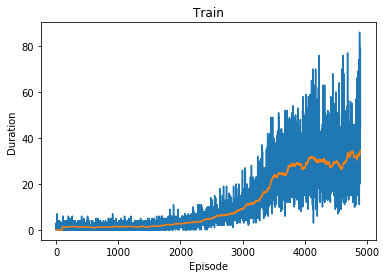

In [8]:
# количество эпизодов, которые играем
NUM_EPISODES = 35000

# количество кадров, между которыми обучаем модель
OPTIMIZE_MODEL_STEP = 5
# количество кадров, между которыми обновляем target-модель
TARGET_UPDATE= 10000

# несколько шагов для разогрева модели()
STEPS_BEFORE_TRAIN = 1000

# параметры для e-greedy стратегии выбора действия
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 1000000
eps_threshold = EPS_START

policy_net.train()
target_net.eval()

test_rewards = []

# Общее число 
steps_done = 0

for e in tqdm_notebook(range(NUM_EPISODES)):
    
    # Условие выхода
    if e >= 100 and np.mean(train_rewards[-100:]) >= 35.0:
        plot_rewards()
        break
    
    # Инициализации различных переменных
    # env - среды
    env.reset()
    # state_holder - хранителя состояния
    state_holder = StateHolder(get_screen())  
    # текущее состояние
    state = state_holder.get()
    # lives - количества жизней в начале эпизода игры (Важно!)
    lives = env.ale.lives()
    # reward'ы за эпизод
    ep_rewards = []
    for t in count():
        
        # Рассчет eps_threshold'а для e-greedy
        if steps_done > EPS_DECAY:
            eps_threshold = EPS_END
        else:
            eps_threshold -= (EPS_START - EPS_END) / EPS_DECAY
        
        # Шаг одного кадра игры 
        steps_done += 1
        
        # действие
        action = select_action(state, eps_threshold)
        _, reward, done, info = env.step(action.item())
        
        # получаем следующее состояние
        state_holder.push(get_screen())
        ep_rewards.append(reward)

        if done:
            next_state = None
            # наказываем сеть
            reward = -1.0
        else:            
            if lives > info['ale.lives']:
                next_state = None
                # обновляем количество жизней
                lives = info['ale.lives']
                # наказываем сеть
                reward = -1.0
            else:
                next_state = state_holder.get()
               
        reward = torch.tensor([reward], device=device)        
        
        # Работа с ReplayMemory
        memory.push(state, action, next_state, reward)
        
        # Код обработки перехода
        state = state_holder.get() if next_state is None else next_state 
        
        # Шаг оптимизации
        if (steps_done > STEPS_BEFORE_TRAIN) and steps_done % OPTIMIZE_MODEL_STEP == 0:
            optimize_model()
        
        # Шаг обновления target'сети
        if steps_done % TARGET_UPDATE == 0:
            # print("Target net updated!")
            target_net.load_state_dict(policy_net.state_dict())
        
        # Код завершающий эпизод игры/обучения
        if done:
            train_rewards.append(np.sum(ep_rewards))
            # Суммарный reward(не дисконтированный) за последний эпизод и средний reward по поsследним 100 эпизодам
            print("Episode : {} Steps done: {} Episode score : {} Mean score : {}".format(e, steps_done, train_rewards[-1], np.mean(train_rewards[-100:])))
            # Отрисовка графика
            plot_rewards()
            break 



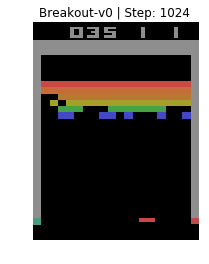

Total game reward : 35.0


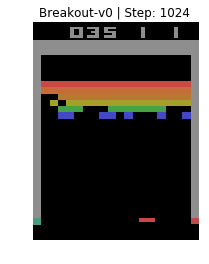

In [9]:
# Тестирование

TEST_EPS = 0.05

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (env.spec.id, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())


policy_net.eval()
env.reset()
state_holder = StateHolder(get_screen())

total_reward = 0

for i in count():
    # Выбрать и выполнить новое действие
    action = select_action(state_holder.get(), TEST_EPS)
    _, reward, done, _ = env.step(action.item())
    total_reward += reward
    # Получаем новое состояние
    if not done:
        state_holder.push(get_screen())
    else:
        break
    show_state(env, i)
    
print("Total game reward : {}".format(total_reward))